In [23]:
# ==============================================================================
# 代码块 1 (修正版): 环境设置与数据加载
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from pathlib import Path

# --- (1) 环境与路径配置 ---
OUTPUT_DIR = Path('./Result')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True) 

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12

print("--- 步骤1：环境设置与数据加载 ---")
# --- (2) 从单一文件加载数据 ---
try:
    INPUT_FILE = Path('../../Data/0/处理后的数据.xlsx')
    df_all = pd.read_excel(INPUT_FILE, sheet_name='已分类清洗后数据')

    # 【核心修正】使用更稳健的方式定义化学成分列
    # 首先选出所有数据类型为数值的列
    numeric_cols = df_all.select_dtypes(include=np.number).columns
    # 然后从数值列中排除已知的非化学成分ID列
    chemical_columns = [col for col in numeric_cols if col not in ['文物编号', '成分总和']]
    
    print("数据加载成功。")
    print(f"总数据集包含 {len(df_all)} 条有效样本。")
    print(f"已识别出 {len(chemical_columns)} 个化学成分列。")

except FileNotFoundError:
    print(f"错误：文件未找到，请确保 '{INPUT_FILE.name}' 与脚本在同一目录下。")
except Exception as e:
    print(f"处理数据时发生错误: {e}")

--- 步骤1：环境设置与数据加载 ---
数据加载成功。
总数据集包含 67 条有效样本。
已识别出 14 个化学成分列。


In [24]:
# ==============================================================================
# 代码块 2: 关系分析的统计检验
# ==============================================================================
if 'df_all' in locals():
    print("\n--- 步骤2：执行关系分析的统计检验 (卡方检验) ---")
    
    relations_to_test = ['类型', '纹饰', '颜色']
    chi2_results = {}

    for col in relations_to_test:
        contingency_table = pd.crosstab(df_all['表面风化'], df_all[col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # 打印并存储结果
        print(f"\n“表面风化”与“{col}”的卡方检验结果:")
        print(f"  - P值: {p:.4f}")
        conclusion = "存在显著统计学关联" if p < 0.05 else "无显著统计学关联"
        print(f"  - 结论: {conclusion} (P < 0.05)")
        chi2_results[col] = {'卡方值': chi2, 'P值': p, '结论': conclusion}

    # 将统计结果保存到文件
    chi2_df = pd.DataFrame(chi2_results).T
    output_chi2_file = OUTPUT_DIR / '问题一_关系分析统计检验结果.csv'
    chi2_df.to_csv(output_chi2_file, encoding='utf-8-sig')
    print(f"\n统计检验结果已保存至: 【{output_chi2_file}】")


--- 步骤2：执行关系分析的统计检验 (卡方检验) ---

“表面风化”与“类型”的卡方检验结果:
  - P值: 0.0064
  - 结论: 存在显著统计学关联 (P < 0.05)

“表面风化”与“纹饰”的卡方检验结果:
  - P值: 0.0572
  - 结论: 无显著统计学关联 (P < 0.05)

“表面风化”与“颜色”的卡方检验结果:
  - P值: 0.0655
  - 结论: 无显著统计学关联 (P < 0.05)

统计检验结果已保存至: 【Result\问题一_关系分析统计检验结果.csv】



--- 步骤3：生成关系分析的可视化图表 ---
关系分析可视化图表已保存至: 【Result\问题一_关系分析可视化.png】


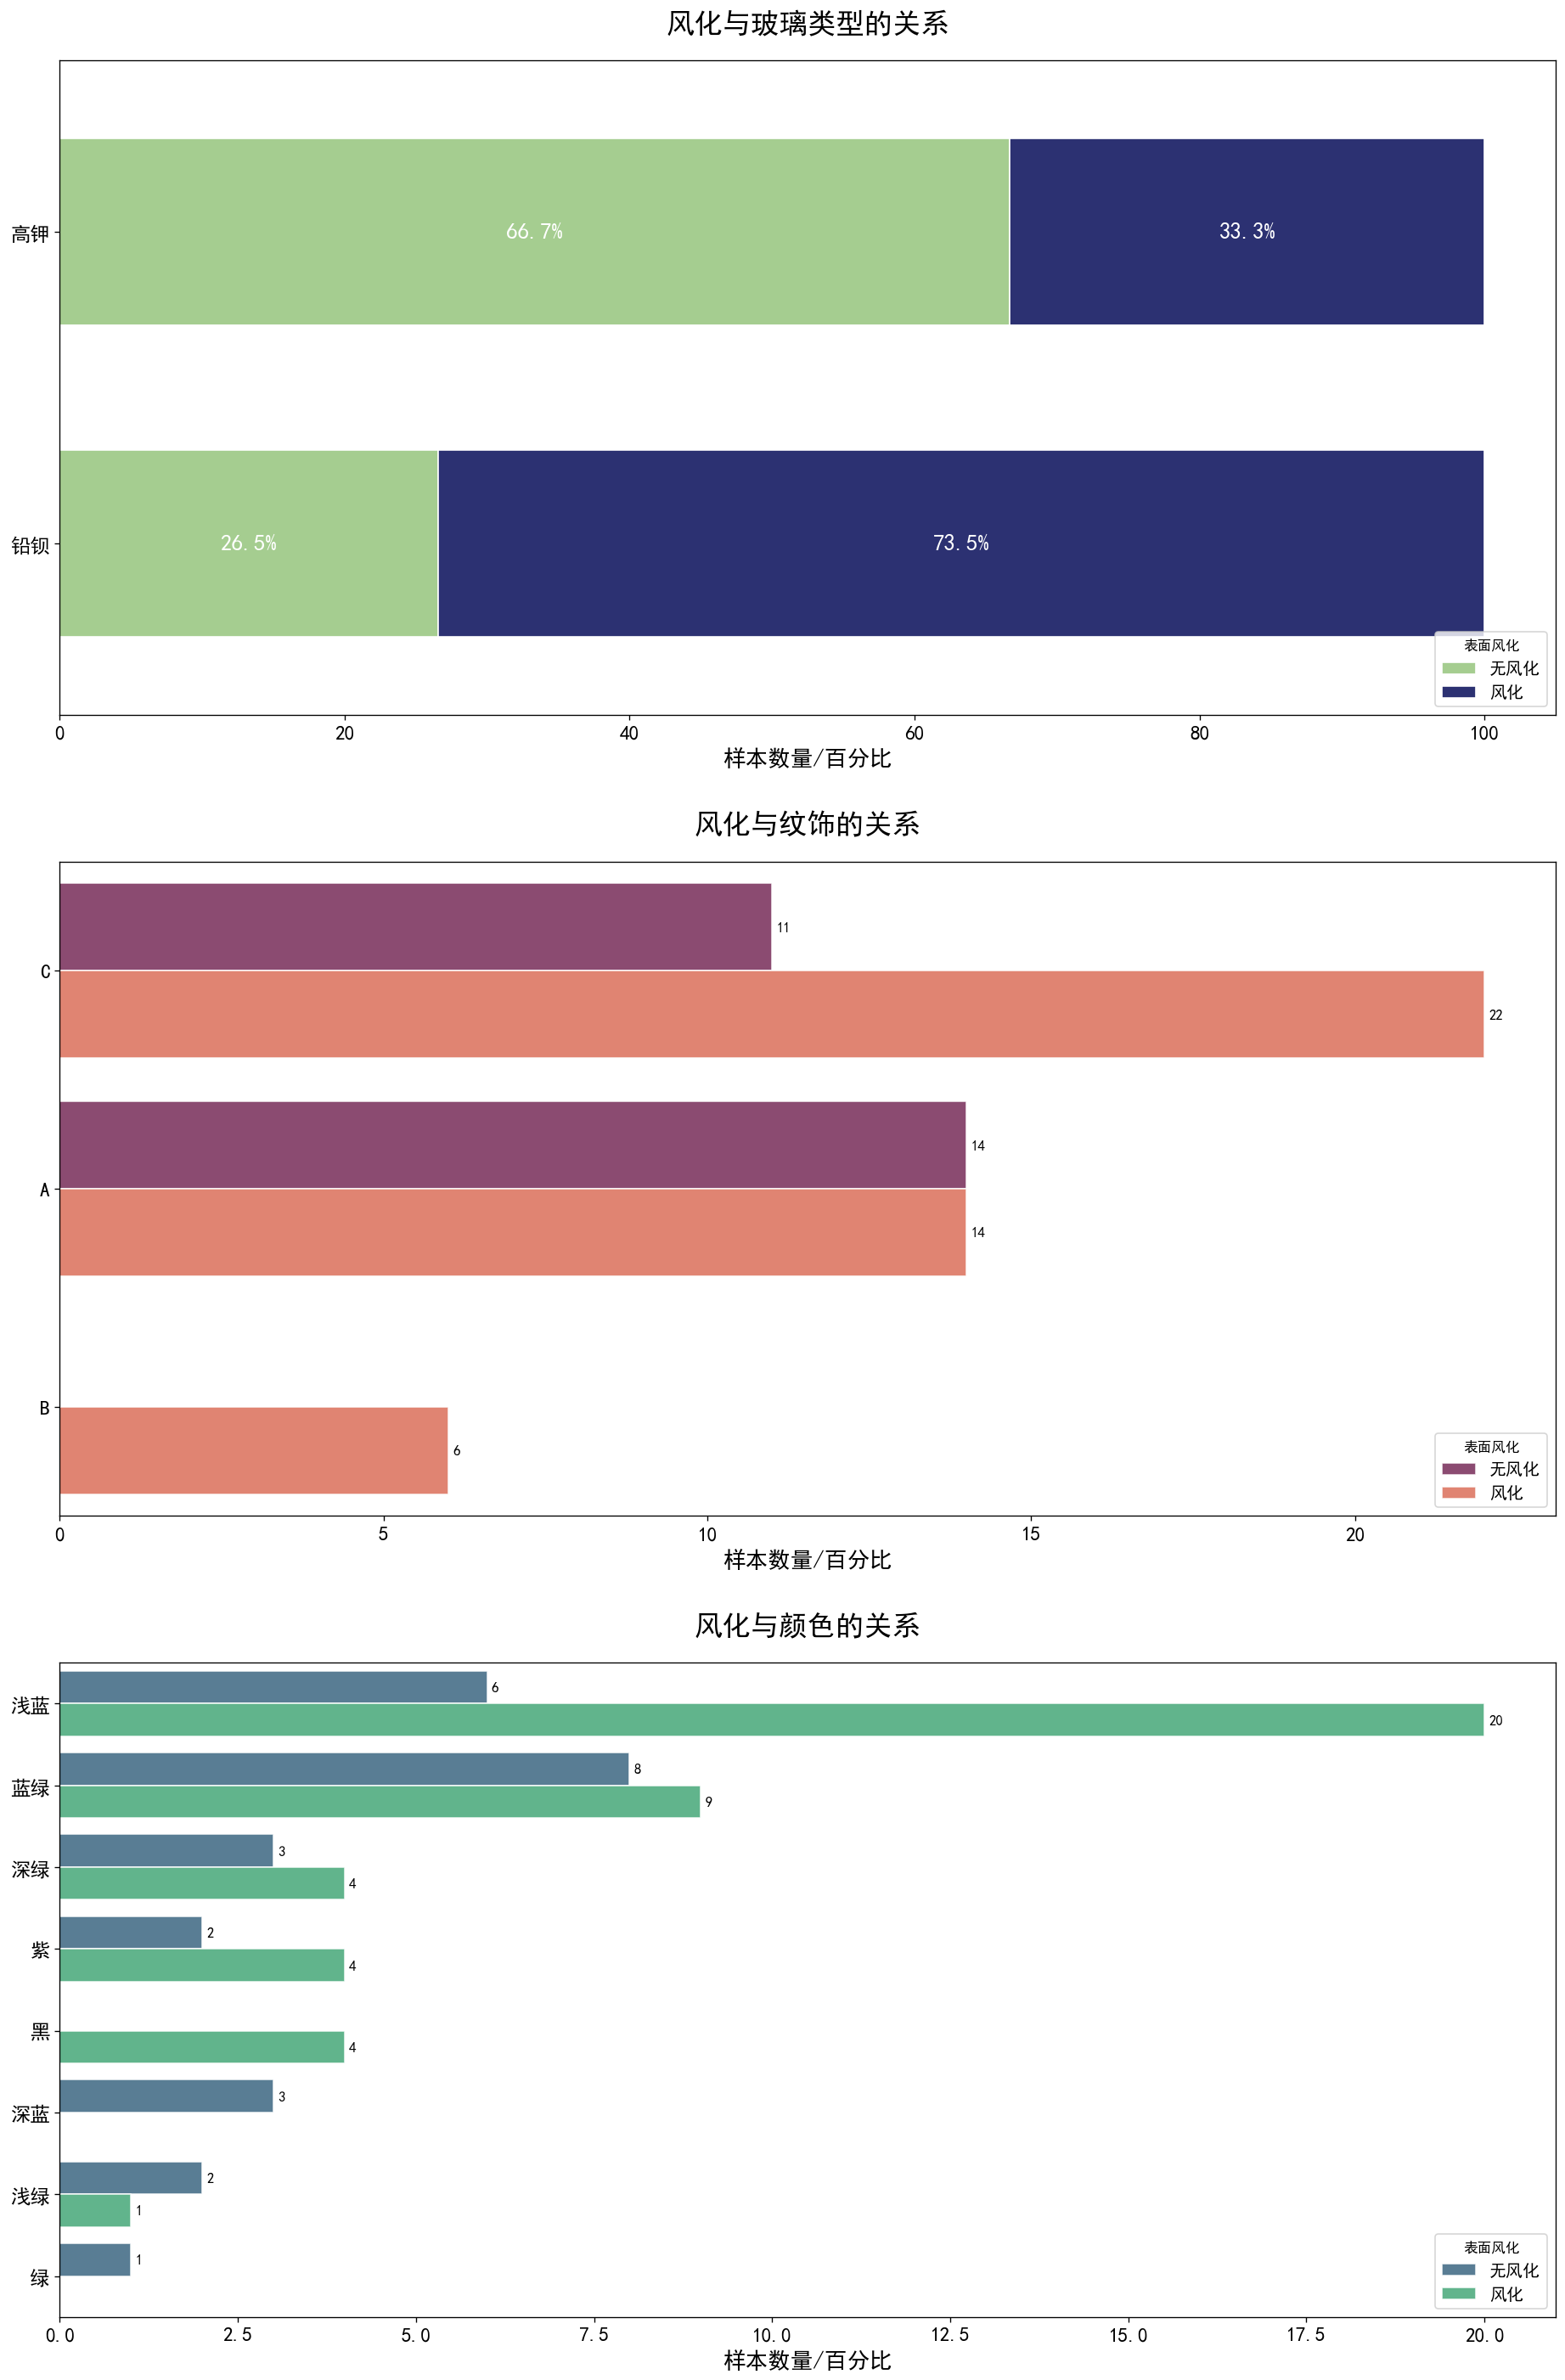

In [25]:
# ==============================================================================
# 代码块 3: 关系分析的可视化
# ==============================================================================
if 'df_all' in locals():
    print("\n--- 步骤3：生成关系分析的可视化图表 ---")

    fig, axes = plt.subplots(3, 1, figsize=(16, 24))

    # 图1: 表面风化与类型的比例关系
    ct_type_percent = pd.crosstab(df_all['类型'], df_all['表面风化'], normalize='index') * 100
    ct_type_percent.plot(kind='barh', stacked=True, ax=axes[0], colormap='crest', width=0.6, edgecolor='white')
    axes[0].set_title('风化与玻璃类型的关系', pad=20)
    for container in axes[0].containers:
        axes[0].bar_label(container, label_type='center', fmt='%.1f%%', color='white', weight='bold', fontsize=16)

    # 图2: 表面风化与纹饰的计数关系
    sns.countplot(y='纹饰', hue='表面风化', data=df_all, ax=axes[1], palette='rocket',
                  order=df_all['纹饰'].value_counts().index, edgecolor='white', alpha=0.85)
    axes[1].set_title('风化与纹饰的关系', pad=20)
    for container in axes[1].containers:
        axes[1].bar_label(container, label_type='edge', padding=3)

    # 图3: 表面风化与颜色的计数关系
    sns.countplot(y='颜色', hue='表面风化', data=df_all, ax=axes[2], palette='viridis',
                  order=df_all['颜色'].value_counts().index, edgecolor='white', alpha=0.85)
    axes[2].set_title('风化与颜色的关系', pad=20)
    for container in axes[2].containers:
        axes[2].bar_label(container, label_type='edge', padding=3)

    # 统一调整格式
    for ax in axes:
        ax.set_xlabel('样本数量/百分比')
        ax.set_ylabel('')
        ax.legend(title='表面风化', loc='lower right')

    plt.tight_layout(pad=3.0)
    output_fig_path = OUTPUT_DIR / '问题一_关系分析可视化.png'
    plt.savefig(output_fig_path)
    print(f"关系分析可视化图表已保存至: 【{output_fig_path}】")
    plt.show()

In [26]:
# ==============================================================================
# 代码块 2: 分组分析 - 描述性统计量
# ==============================================================================
if 'df_all' in locals() and 'chemical_columns' in locals():
    print("\n--- 步骤2：执行分组分析 - 描述性统计量计算 ---")

    # (1) 按“类型”和“表面风化”进行分组
    grouped_stats = df_all.groupby(['类型', '表面风化'])[chemical_columns]

    # (2) 计算全面的描述性统计数据
    # 我们转置(T)结果，使得化学成分为行，统计量为列，更便于阅读
    descriptive_stats = grouped_stats.describe().T

    # (3) 打印并保存结果
    print("各分组的描述性统计结果 (部分展示):")
    # 为了方便在notebook中查看，我们只展示一个成分的例子
    print(descriptive_stats.loc['二氧化硅(SiO2)'])
    
    output_stats_path = OUTPUT_DIR / '问题一_分组描述性统计.xlsx'
    descriptive_stats.to_excel(output_stats_path)
    
    print(f"\n完整的描述性统计数据已保存至Excel文件: 【{output_stats_path}】")


--- 步骤2：执行分组分析 - 描述性统计量计算 ---
各分组的描述性统计结果 (部分展示):
类型            铅钡                    高钾           
表面风化         无风化         风化        无风化         风化
count  13.000000  36.000000  12.000000   6.000000
mean   53.443846  33.614722  67.984167  93.963333
std    14.587271  17.221484   8.755099   1.733617
min    31.940000   3.720000  59.010000  92.350000
25%    37.360000  21.047500  61.677500  92.652500
50%    55.210000  29.395000  65.530000  93.505000
75%    65.910000  50.772500  71.167500  94.837500
max    75.510000  68.080000  87.050000  96.770000

完整的描述性统计数据已保存至Excel文件: 【Result\问题一_分组描述性统计.xlsx】



--- 步骤3：执行分组分析 - 数据分布可视化 ---
成分 [二氧化硅(SiO2)] 的分布图已保存至: 【Result\问题一_分布图_二氧化硅(SiO2).png】


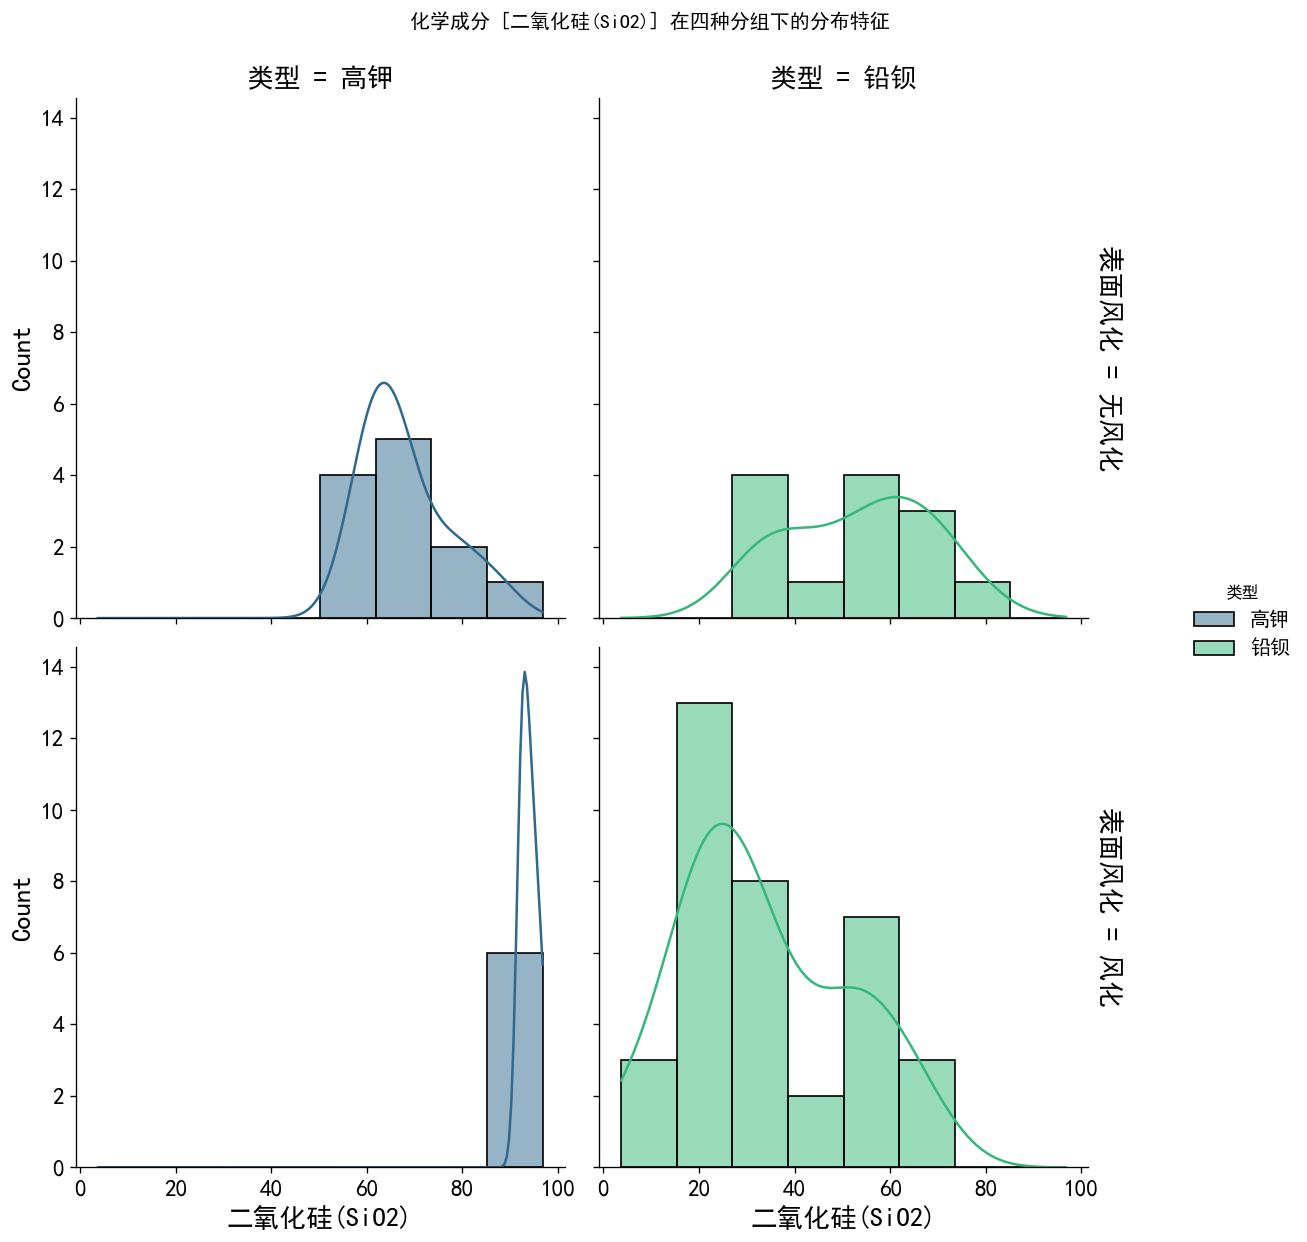

成分 [氧化钾(K2O)] 的分布图已保存至: 【Result\问题一_分布图_氧化钾(K2O).png】


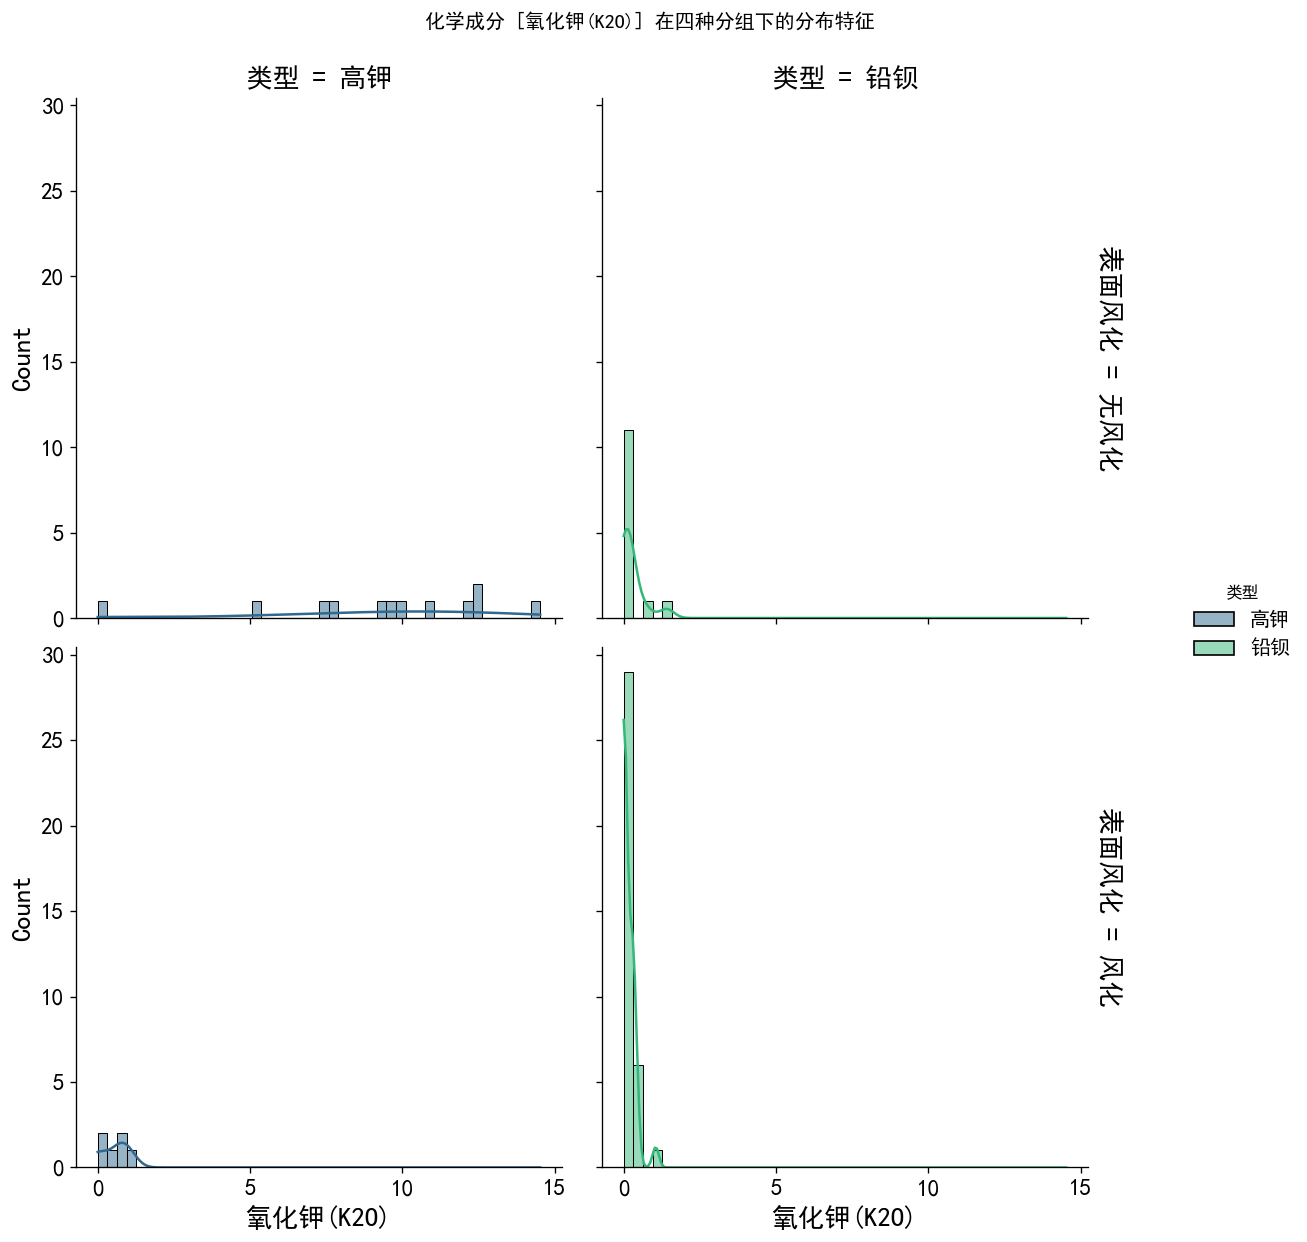

成分 [氧化铅(PbO)] 的分布图已保存至: 【Result\问题一_分布图_氧化铅(PbO).png】


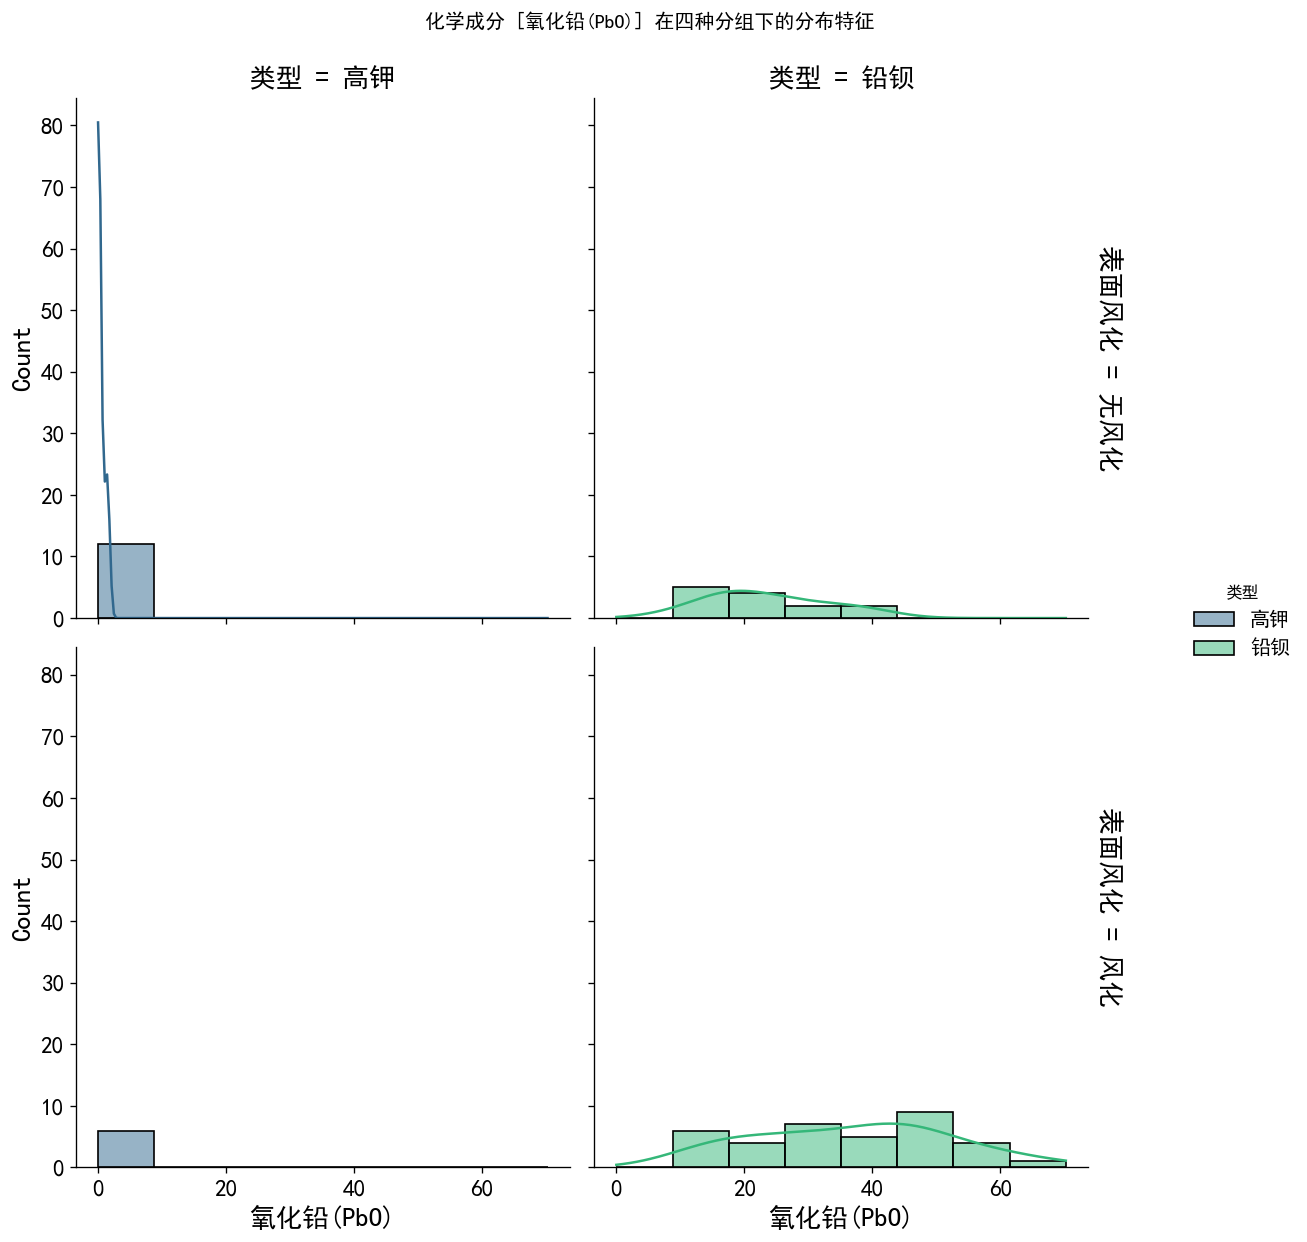

成分 [氧化钡(BaO)] 的分布图已保存至: 【Result\问题一_分布图_氧化钡(BaO).png】


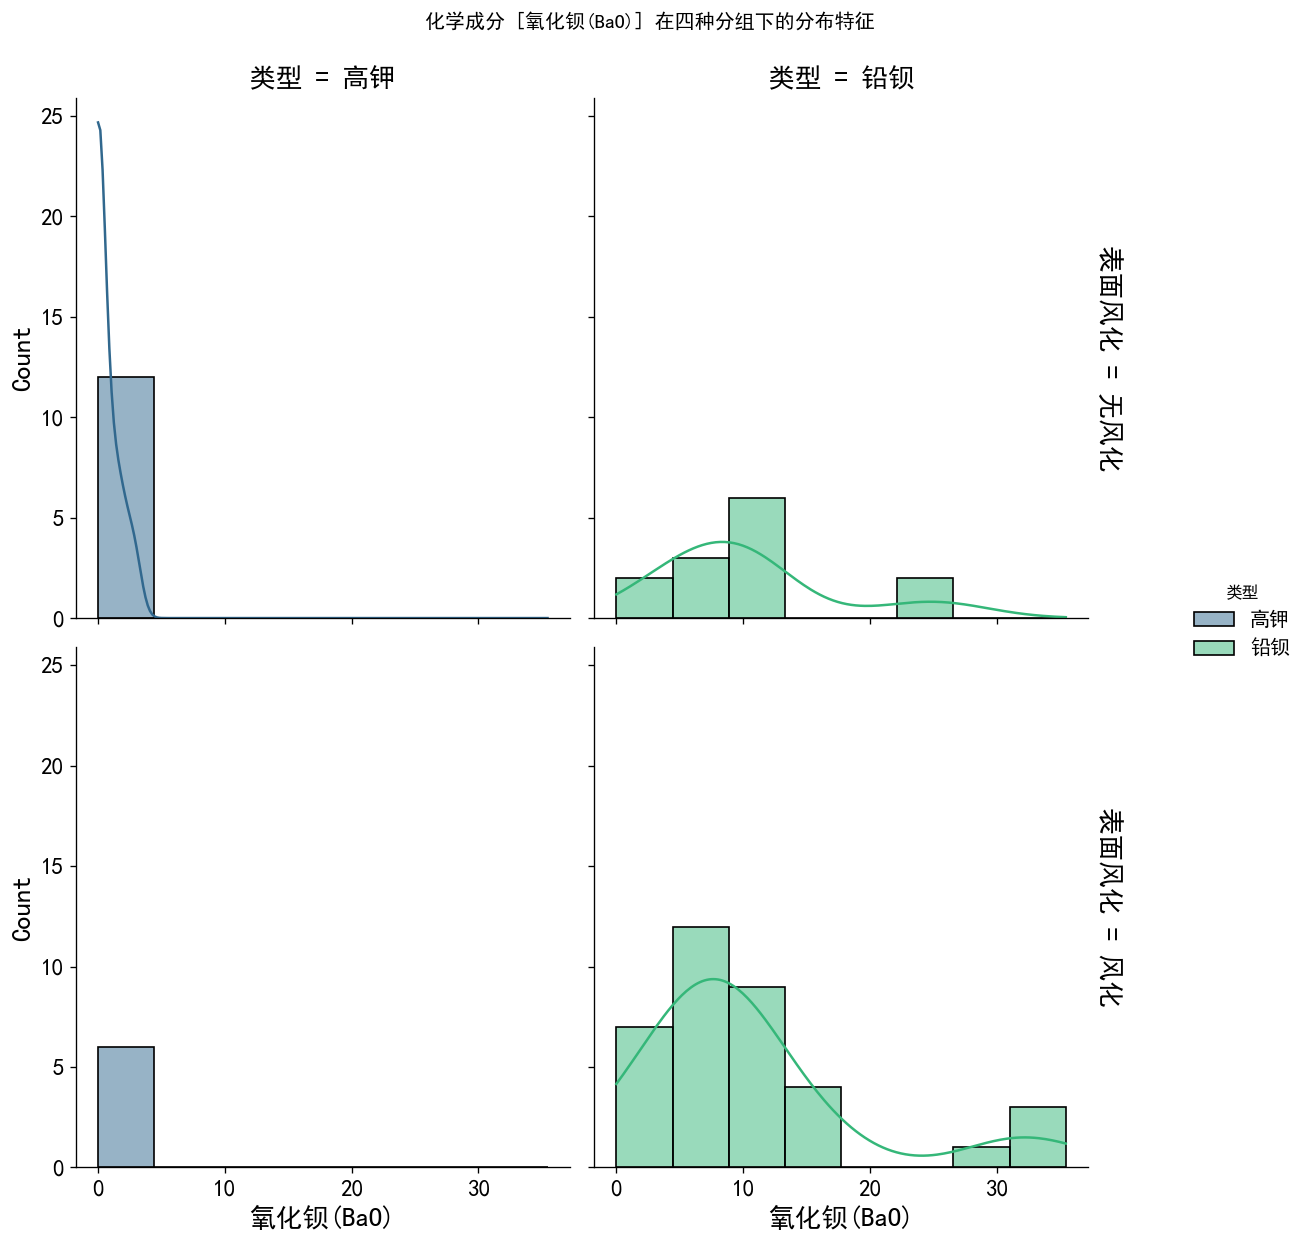

In [27]:
# ==============================================================================
# 代码块 3 (修正版): 分组分析 - 数据分布特征可视化
# ==============================================================================
if 'df_all' in locals() and 'chemical_columns' in locals():
    print("\n--- 步骤3：执行分组分析 - 数据分布可视化 ---")

    # (1) 选取几个关键化学成分进行分布展示
    key_chemicals_dist = ['二氧化硅(SiO2)', '氧化钾(K2O)', '氧化铅(PbO)', '氧化钡(BaO)']

    # (2) 遍历每个成分，绘制分面直方图
    for chemical in key_chemicals_dist:
        # 使用displot可以方便地进行分面
        g = sns.displot(
            data=df_all,
            x=chemical,
            col="类型",       # 按“类型”分列
            row="表面风化",   # 按“表面风化”分行
            hue="类型",       # 按“类型”上色
            kind="hist",     # 绘制直方图
            kde=True,        # 叠加核密度估计曲线
            palette='viridis',
            # 【核心修正】将margin_titles参数放入facet_kws字典中
            facet_kws={'margin_titles': True}
        )
        g.fig.suptitle(f'化学成分 [{chemical}] 在四种分组下的分布特征', y=1.03)
        
        # 遵照您的要求，保存中文命名的图片
        output_dist_path = OUTPUT_DIR / f'问题一_分布图_{chemical}.png'
        plt.savefig(output_dist_path)
        print(f"成分 [{chemical}] 的分布图已保存至: 【{output_dist_path}】")
        # 遵照您的要求，在notebook中直接显示图片
        plt.show()


--- 正在按您的最终美学要求（无风化深色，风化浅色）重构可视化图表 ---


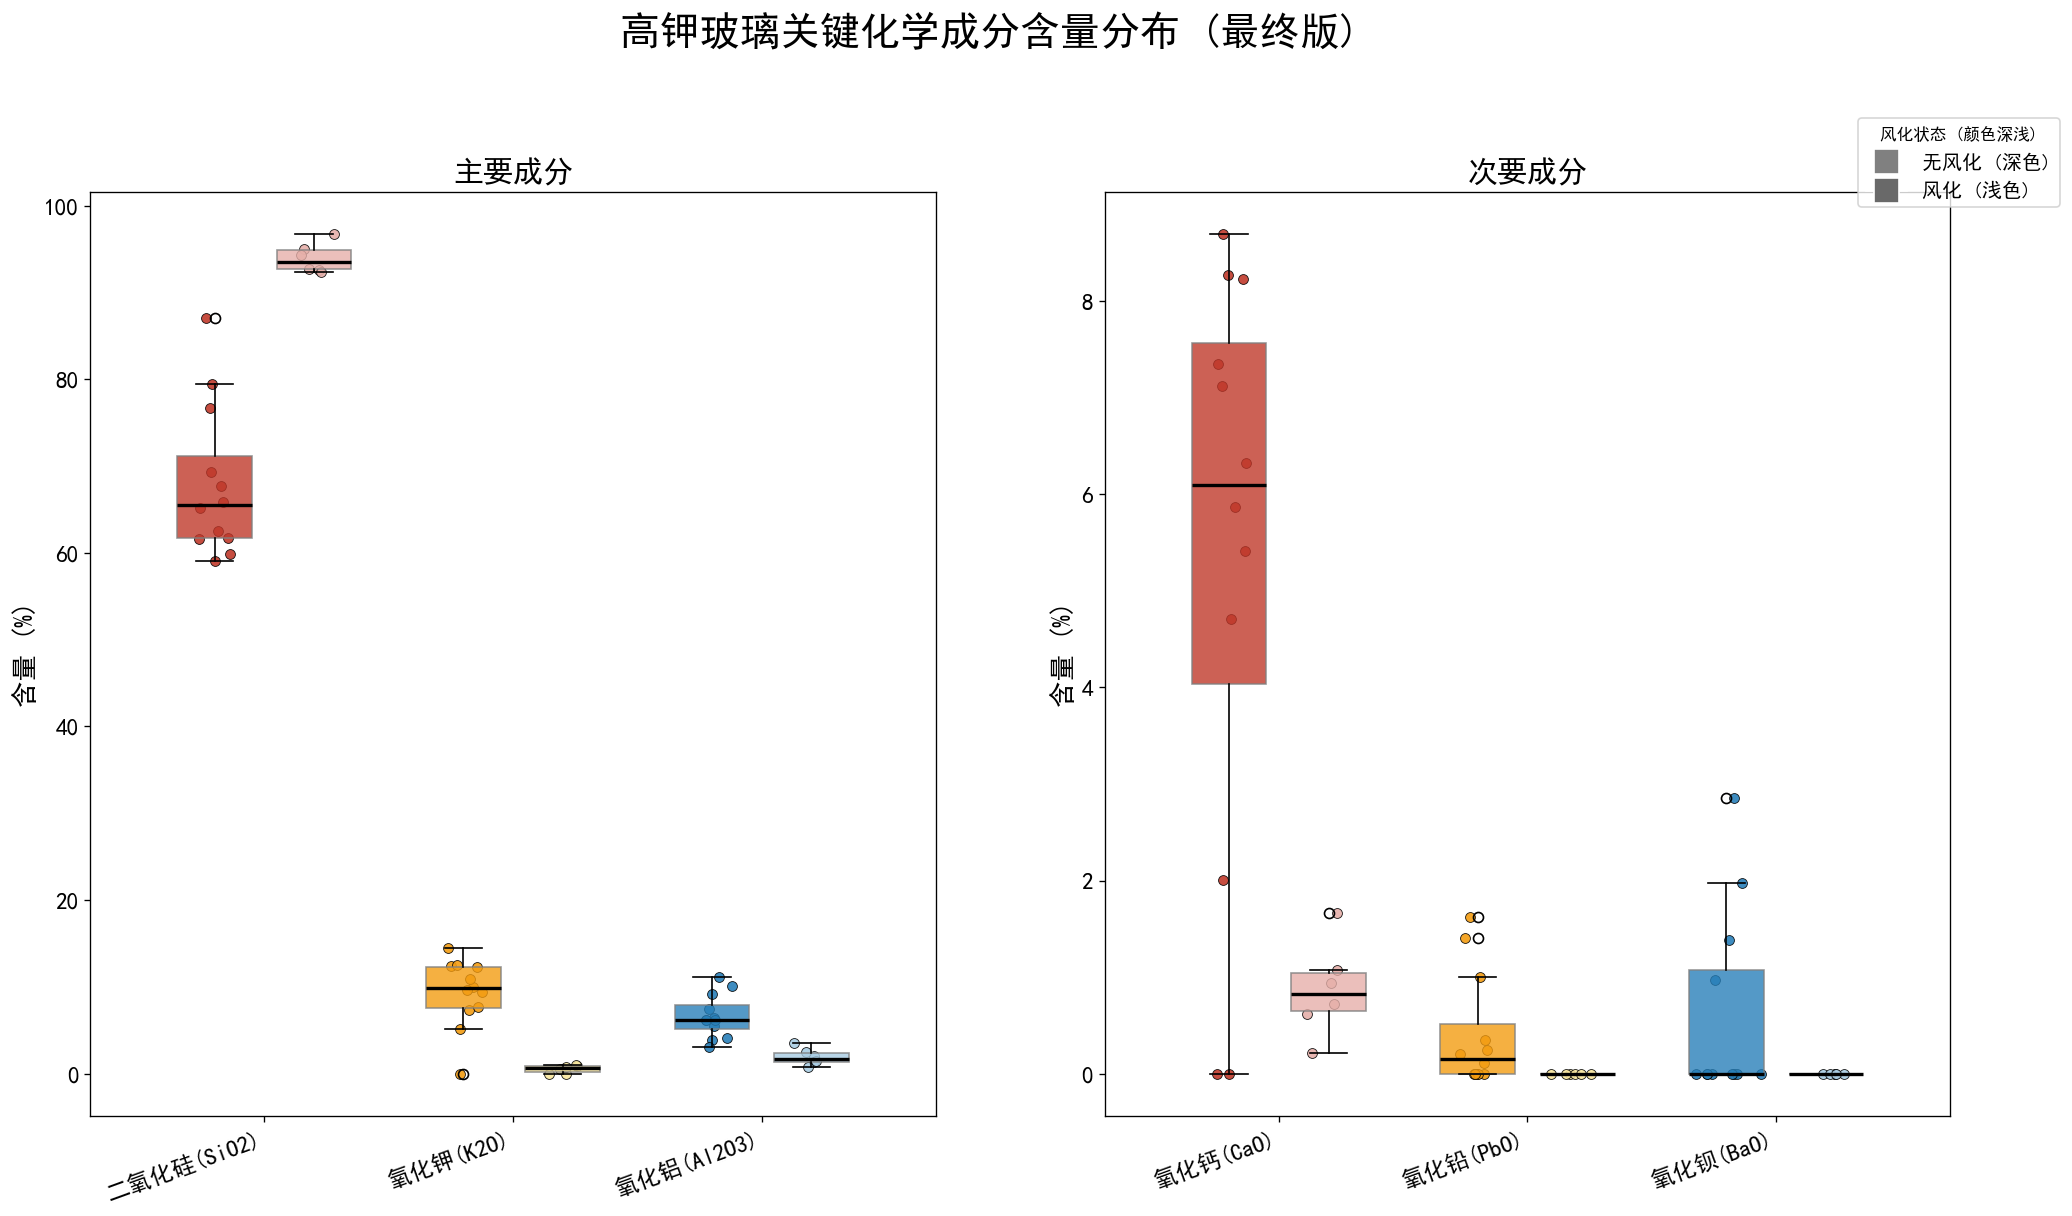

高钾玻璃最终版定制图已保存至: 【Result\问题一_高钾玻璃成分分布_最终版_v3.png】


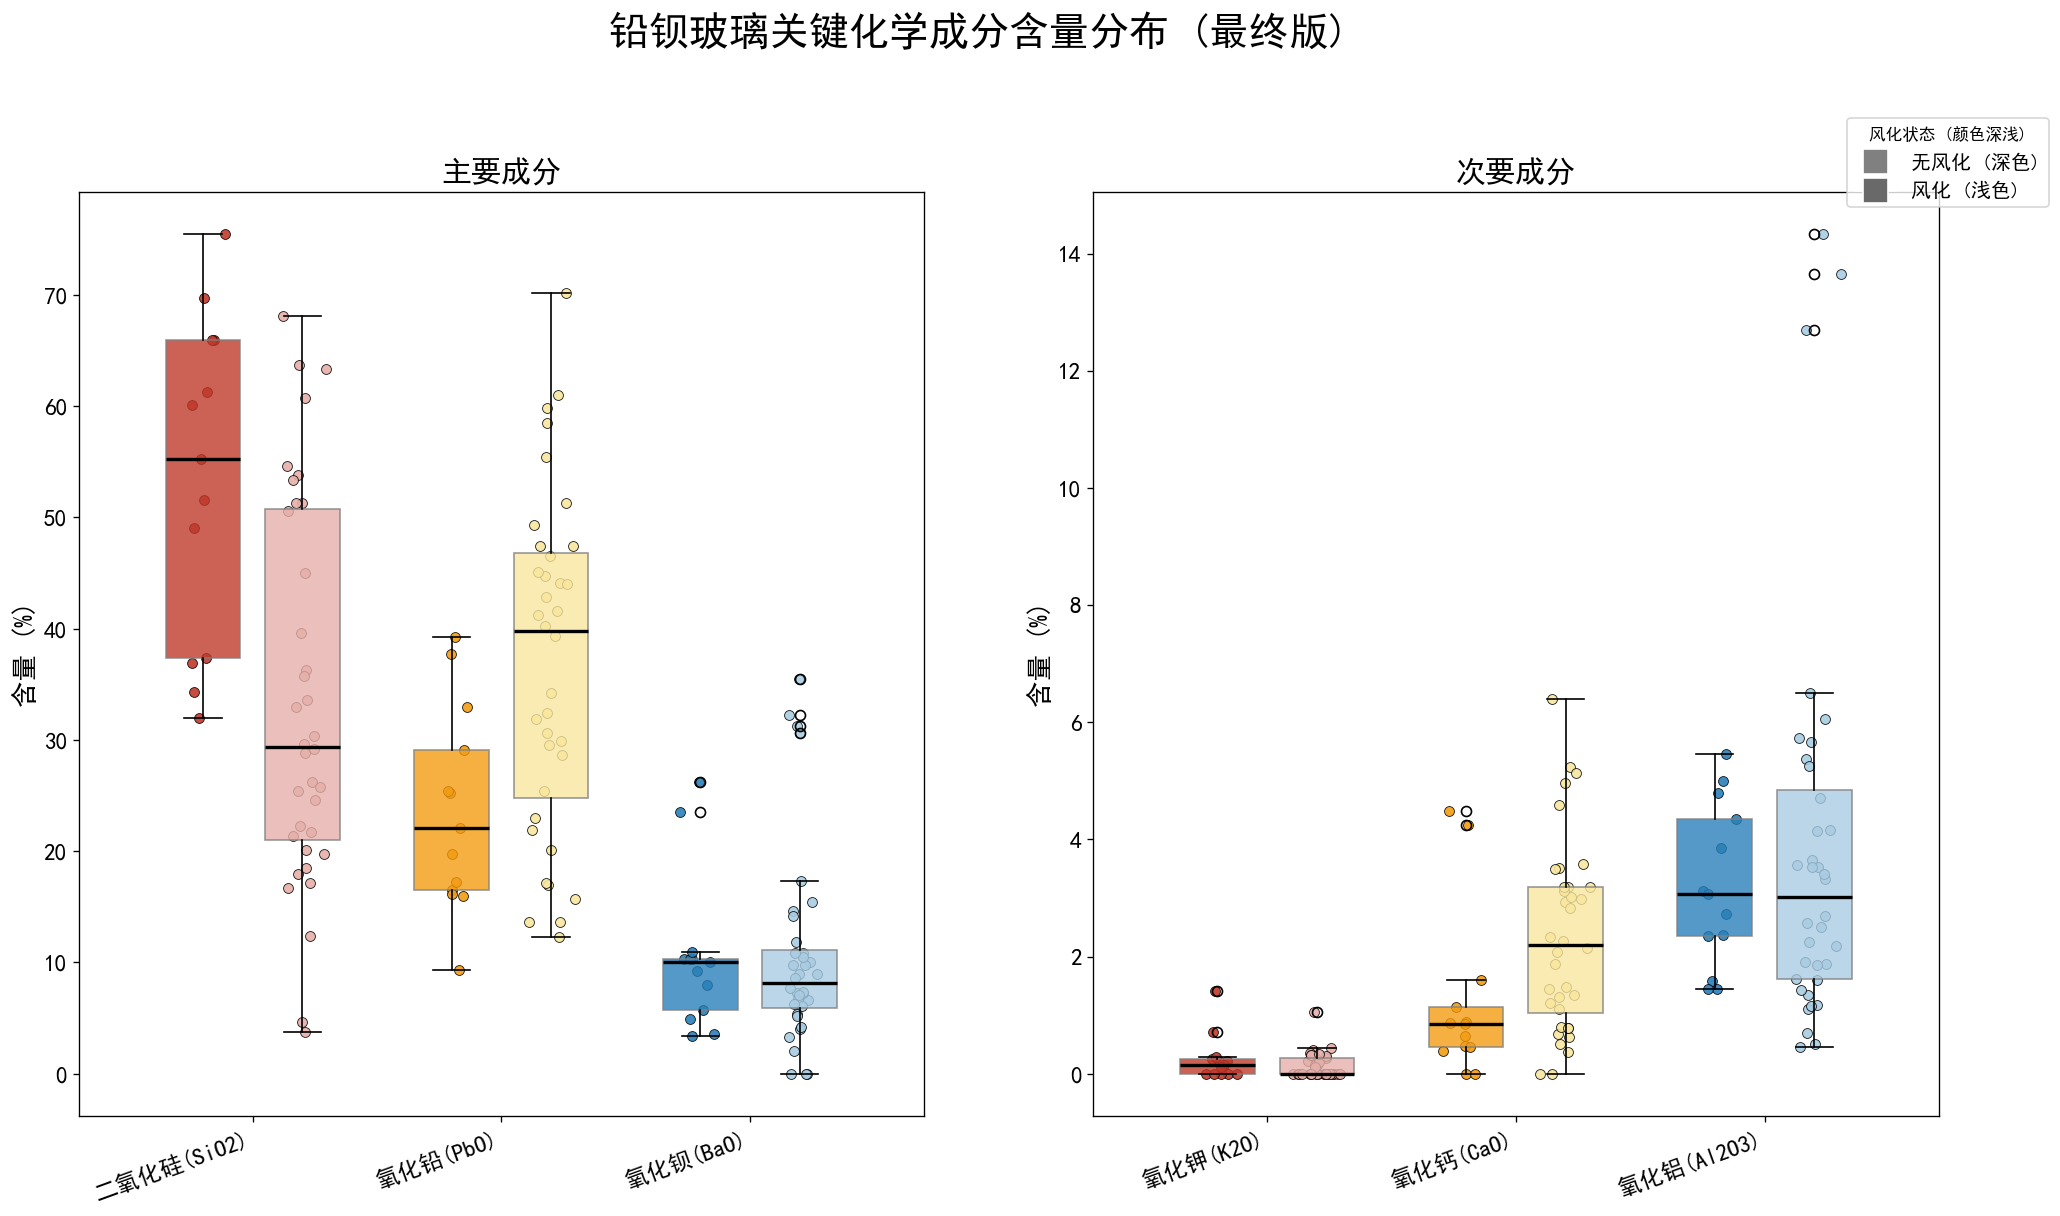

铅钡玻璃最终版定制图已保存至: 【Result\问题一_铅钡玻璃成分分布_最终版_v3.png】


In [28]:
# ==============================================================================
# 代码块：按最终美学要求精修化学成分分布图 (颜色反转版)
# ==============================================================================
if 'df_all' in locals():
    print("\n--- 正在按您的最终美学要求（无风化深色，风化浅色）重构可视化图表 ---")

    # (1) 定义最终的“红黄蓝”色系
    # 每个元组内部分别是 (无风化颜色(深), 风化颜色(浅))
    color_pairs = [
        ('#C0392B', '#E6B0AA'), # 深红 / 浅红
        ('#F39C12', '#F9E79F'), # 深黄 / 浅黄
        ('#2980B9', '#A9CCE3')  # 深蓝 / 浅蓝
    ]

    # (2) 筛选出两大类玻璃的数据 (不变)
    df_high_k = df_all[df_all['类型'] == '高钾'].copy()
    df_lead_ba = df_all[df_all['类型'] == '铅钡'].copy()

    # (3) 定义两组图各自需要展示的化学成分 (不变)
    high_k_group1 = ['二氧化硅(SiO2)', '氧化钾(K2O)', '氧化铝(Al2O3)']
    high_k_group2 = ['氧化钙(CaO)', '氧化铅(PbO)', '氧化钡(BaO)']
    
    lead_ba_group1 = ['二氧化硅(SiO2)', '氧化铅(PbO)', '氧化钡(BaO)']
    lead_ba_group2 = ['氧化钾(K2O)', '氧化钙(CaO)', '氧化铝(Al2O3)']
    
    # ==================== 绘制第一张图：高钾玻璃 ====================

    fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
    fig1.suptitle('高钾玻璃关键化学成分含量分布 (最终版)', fontsize=24, y=1.03)

    # --- 绘制左子图 (高钾组1) ---
    for i, chemical in enumerate(high_k_group1):
        deep_color, light_color = color_pairs[i]
        unweathered_data = df_high_k[df_high_k['表面风化'] == '无风化'][chemical].dropna()
        weathered_data = df_high_k[df_high_k['表面风化'] == '风化'][chemical].dropna()
        
        # 绘制“无风化”箱体和散点 (使用深色)
        bp1 = axes1[0].boxplot(unweathered_data, positions=[i - 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        for patch in bp1['boxes']: patch.set_facecolor(deep_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        unweathered_x = np.random.normal(i - 0.2, 0.04, size=len(unweathered_data))
        axes1[0].scatter(unweathered_x, unweathered_data, color=deep_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)
        
        # 绘制“风化”箱体和散点 (使用浅色)
        bp2 = axes1[0].boxplot(weathered_data, positions=[i + 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        for patch in bp2['boxes']: patch.set_facecolor(light_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        weathered_x = np.random.normal(i + 0.2, 0.04, size=len(weathered_data))
        axes1[0].scatter(weathered_x, weathered_data, color=light_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)

    # --- 绘制右子图 (高钾组2) ---
    for i, chemical in enumerate(high_k_group2):
        deep_color, light_color = color_pairs[i]
        unweathered_data = df_high_k[df_high_k['表面风化'] == '无风化'][chemical].dropna()
        weathered_data = df_high_k[df_high_k['表面风化'] == '风化'][chemical].dropna()
        bp1 = axes1[1].boxplot(unweathered_data, positions=[i - 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        bp2 = axes1[1].boxplot(weathered_data, positions=[i + 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        for patch in bp1['boxes']: patch.set_facecolor(deep_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        for patch in bp2['boxes']: patch.set_facecolor(light_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        unweathered_x = np.random.normal(i - 0.2, 0.04, size=len(unweathered_data))
        axes1[1].scatter(unweathered_x, unweathered_data, color=deep_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)
        weathered_x = np.random.normal(i + 0.2, 0.04, size=len(weathered_data))
        axes1[1].scatter(weathered_x, weathered_data, color=light_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)

    # --- 统一格式化和图例 (修正图例文字) ---
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='s', color='w', label='无风化 (深色)', markerfacecolor='gray', markersize=15),
                       Line2D([0], [0], marker='s', color='w', label='风化 (浅色)', markerfacecolor='dimgray', markersize=15)]
    fig1.legend(handles=legend_elements, title="风化状态 (颜色深浅)", loc='upper right', bbox_to_anchor=(0.95, 0.95))

    axes1[0].set_xticks(range(len(high_k_group1))); axes1[0].set_xticklabels(high_k_group1, rotation=20, ha='right')
    axes1[1].set_xticks(range(len(high_k_group2))); axes1[1].set_xticklabels(high_k_group2, rotation=20, ha='right')
    axes1[0].set_title('主要成分', fontsize=18); axes1[1].set_title('次要成分', fontsize=18)
    for ax in axes1: ax.set_xlabel(''); ax.set_ylabel('含量 (%)')

    output_path1 = OUTPUT_DIR / '问题一_高钾玻璃成分分布_最终版_v3.png'
    plt.savefig(output_path1, bbox_inches='tight')
    plt.show()
    print(f"高钾玻璃最终版定制图已保存至: 【{output_path1}】")

    # ==================== 绘制第二张图：铅钡玻璃 (逻辑同上) ====================

    fig2, axes2 = plt.subplots(1, 2, figsize=(20, 10))
    fig2.suptitle('铅钡玻璃关键化学成分含量分布 (最终版)', fontsize=24, y=1.03)

    for i, chemical in enumerate(lead_ba_group1):
        deep_color, light_color = color_pairs[i]
        unweathered_data = df_lead_ba[df_lead_ba['表面风化'] == '无风化'][chemical].dropna()
        weathered_data = df_lead_ba[df_lead_ba['表面风化'] == '风化'][chemical].dropna()
        bp1 = axes2[0].boxplot(unweathered_data, positions=[i - 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        bp2 = axes2[0].boxplot(weathered_data, positions=[i + 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        for patch in bp1['boxes']: patch.set_facecolor(deep_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        for patch in bp2['boxes']: patch.set_facecolor(light_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        unweathered_x = np.random.normal(i - 0.2, 0.04, size=len(unweathered_data))
        weathered_x = np.random.normal(i + 0.2, 0.04, size=len(weathered_data))
        axes2[0].scatter(unweathered_x, unweathered_data, color=deep_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)
        axes2[0].scatter(weathered_x, weathered_data, color=light_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)

    for i, chemical in enumerate(lead_ba_group2):
        deep_color, light_color = color_pairs[i]
        unweathered_data = df_lead_ba[df_lead_ba['表面风化'] == '无风化'][chemical].dropna()
        weathered_data = df_lead_ba[df_lead_ba['表面风化'] == '风化'][chemical].dropna()
        bp1 = axes2[1].boxplot(unweathered_data, positions=[i - 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        bp2 = axes2[1].boxplot(weathered_data, positions=[i + 0.2], widths=0.3, patch_artist=True, medianprops={'color': 'black', 'linewidth': 2})
        for patch in bp1['boxes']: patch.set_facecolor(deep_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        for patch in bp2['boxes']: patch.set_facecolor(light_color); patch.set_edgecolor('gray'); patch.set_alpha(0.8)
        unweathered_x = np.random.normal(i - 0.2, 0.04, size=len(unweathered_data))
        weathered_x = np.random.normal(i + 0.2, 0.04, size=len(weathered_data))
        axes2[1].scatter(unweathered_x, unweathered_data, color=deep_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)
        axes2[1].scatter(weathered_x, weathered_data, color=light_color, s=35, edgecolor='black', linewidth=0.5, alpha=0.9)

    fig2.legend(handles=legend_elements, title="风化状态 (颜色深浅)", loc='upper right', bbox_to_anchor=(0.95, 0.95))
    
    axes2[0].set_xticks(range(len(lead_ba_group1))); axes2[0].set_xticklabels(lead_ba_group1, rotation=20, ha='right')
    axes2[1].set_xticks(range(len(lead_ba_group2))); axes2[1].set_xticklabels(lead_ba_group2, rotation=20, ha='right')
    axes2[0].set_title('主要成分', fontsize=18); axes2[1].set_title('次要成分', fontsize=18)
    for ax in axes2: ax.set_xlabel(''); ax.set_ylabel('含量 (%)')

    output_path2 = OUTPUT_DIR / '问题一_铅钡玻璃成分分布_最终版_v3.png'
    plt.savefig(output_path2, bbox_inches='tight')
    plt.show()
    print(f"铅钡玻璃最终版定制图已保存至: 【{output_path2}】")

In [29]:
# ==============================================================================
# 代码块 5 (最终修正版): 风化前成分预测模型
# ==============================================================================
if 'df_all' in locals():
    print("\n--- 步骤5：执行风化前成分预测 ---")
    
    # --- (1) 构建模型：计算“风化系数(k)”向量 (此部分逻辑不变) ---
    df_unweathered = df_all[df_all['表面风化'] == '无风化']
    df_weathered = df_all[df_all['表面风化'] == '风化']

    mean_unweathered = df_unweathered.groupby('类型')[chemical_columns].mean()
    mean_weathered = df_weathered.groupby('类型')[chemical_columns].mean()

    # 处理可能不存在某一类别的情况
    if '高钾' in mean_unweathered.index and '高钾' in mean_weathered.index:
        with np.errstate(divide='ignore', invalid='ignore'):
            k_K = 1 - (mean_weathered.loc['高钾'].to_numpy() / mean_unweathered.loc['高钾'].to_numpy())
        k_K[~np.isfinite(k_K)] = 0
        k_vector_k = pd.Series(k_K, index=chemical_columns)
        print("“风化系数(k)”模型(高钾)构建完成。")
    else:
        k_vector_k = pd.Series(0, index=chemical_columns)
        print("警告: 高钾玻璃数据不全，无法构建精确模型。")

    if '铅钡' in mean_unweathered.index and '铅钡' in mean_weathered.index:
        with np.errstate(divide='ignore', invalid='ignore'):
            k_PbBa = 1 - (mean_weathered.loc['铅钡'].to_numpy() / mean_unweathered.loc['铅钡'].to_numpy())
        k_PbBa[~np.isfinite(k_PbBa)] = 0
        k_vector_pbba = pd.Series(k_PbBa, index=chemical_columns)
        print("“风化系数(k)”模型(铅钡)构建完成。")
    else:
        k_vector_pbba = pd.Series(0, index=chemical_columns)
        print("警告: 铅钡玻璃数据不全，无法构建精确模型。")
    
    # --- (2) 执行预测 ---
    results_list = []
    for index, row in df_weathered.iterrows():
        sample_type = row['类型']
        weathered_composition = row[chemical_columns]
        
        # 【核心修正】在计算前强制净化数据类型，确保万无一失
        weathered_composition = pd.to_numeric(weathered_composition, errors='coerce').fillna(0)
        
        if sample_type == '高钾':
            denominator = 1 - k_vector_k
        else: # 铅钡
            denominator = 1 - k_vector_pbba
        
        pred_array = np.divide(
            weathered_composition.to_numpy(), 
            denominator.to_numpy(), 
            out=np.zeros_like(weathered_composition.to_numpy(), dtype=float), 
            where=denominator.to_numpy()!=0
        )
        preliminary_prediction = pd.Series(pred_array, index=chemical_columns)

        predicted_sum = preliminary_prediction.sum()
        correction_factor = 1.0
        if predicted_sum < 85:
            correction_factor = 85 / predicted_sum if predicted_sum > 0 else 0
        elif predicted_sum > 105:
            correction_factor = 105 / predicted_sum
        
        final_prediction = preliminary_prediction * correction_factor
        final_prediction.fillna(0, inplace=True)
        final_prediction[final_prediction < 0] = 0
        
        pred_dict = final_prediction.to_dict()
        pred_dict['文物采样点'] = row.get('文物采样点', f'未知样本_{index}')
        pred_dict['类型'] = sample_type
        results_list.append(pred_dict)

    df_predictions = pd.DataFrame(results_list)
    print("所有风化样本预测完成。")

    # --- (3) 整理并输出成果 ---
    df_weathered_renamed = df_weathered.rename(columns={col: f"原始含量_{col}" for col in chemical_columns})
    df_predictions_renamed = df_predictions.rename(columns={col: f"预测含量_{col}" for col in chemical_columns})
    df_final_output = pd.merge(df_weathered_renamed, df_predictions_renamed, on=['文物采样点', '类型'])
    
    id_cols = ['文物采样点', '类型']
    cols_sorted = id_cols + sorted([col for col in df_final_output.columns if col not in id_cols])
    df_final_output = df_final_output[cols_sorted]
    
    output_pred_path = OUTPUT_DIR / '问题一_预测结果(融合模型法).xlsx'
    df_final_output.to_excel(output_pred_path, index=False, engine='openpyxl')
    print(f"预测结果已保存至: 【{output_pred_path}】")


--- 步骤5：执行风化前成分预测 ---
“风化系数(k)”模型(高钾)构建完成。
“风化系数(k)”模型(铅钡)构建完成。
所有风化样本预测完成。
预测结果已保存至: 【Result\问题一_预测结果(融合模型法).xlsx】
